A* is an informed search algorithm, or a best-first search, meaning that it is formulated in terms of weighted graphs: starting from a specific starting node of a graph, it aims to find a path to the given goal node having the smallest cost (least distance travelled, shortest time, etc.). It does this by maintaining a tree of paths originating at the start node and extending those paths one edge at a time until its termination criterion is satisfied. 

### Load libraries.

In [1]:
import numpy as np
import pandas as pd
import heapq
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt

### Read data files.

Each row of `df_nodes` is of the form ID, x, y, heuristic-cost-to-go. ID is the unique integer ID number of the node, and these ID numbers should take values 1 through N. The values x and y are the (x,y) coordinates of the node in the plane. Heuristic-cost-to-go is an optimistic approximation of the shortest path from this node to the goal node (e.g., the Euclidean distance to the goal node). If there are N nodes, numbered 1...N in `df_nodes.csv`, you can assume that node 1 is the start node and node N is the goal node.

In [2]:
col_names = ['id', 'x', 'y', 'heuristic_cost']
df_nodes = pd.read_csv('planar_graph/nodes.csv', sep=',', comment='#', header=None, names=col_names)
df_nodes.head()

,id,x,y,heuristic_cost
0,1,-0.5000,-0.5000,1.4142
1,2,-0.0900,-0.4000,1.0762
2,3,-0.2850,-0.3050,1.1244
3,4,0.0575,-0.2250,0.8494
4,5,-0.0525,-0.0175,0.7604


If the graph has E edges, then the data in `df_edges` has E rows. Each row is of the form ID1, ID2, cost. ID1 and ID2 are the node IDs of the nodes connected by the edge. The feature actual_cost is the cost (weight) of traversing that edge.

In [3]:
col_names = ['id1', 'id2', 'actual_cost']
df_edges = pd.read_csv('planar_graph/edges.csv', sep=',', comment='#', header=None, names=col_names)
df_edges.head()

,id1,id2,actual_cost
0,12,11,0.2140
1,12,10,0.3135
2,12,8,0.5014
3,11,10,0.1778
4,11,9,0.4454


### Visualize graph.

NetworkX (imported as `nx`) is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

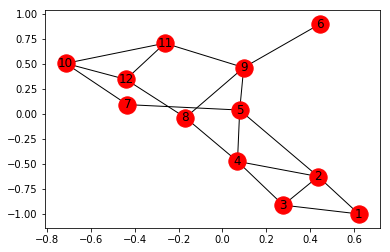

Shortest path found by networkx: [1, 3, 4, 8, 12]


In [4]:
G = nx.Graph()
G.add_nodes_from(df_nodes['id'])
G.add_weighted_edges_from(zip(df_edges['id1'], df_edges['id2'], df_edges['actual_cost']))
nx.draw_networkx(G)
plt.show()
# using default search algorithm
shortest_path_nx = nx.shortest_path(G,1,12)
print("Shortest path found by networkx:", shortest_path_nx)

### A$^{*}$-search algorithm.

The function `astar_search` returns the shortest path between the start node and the goal node, if one exists, as well as a dictionary containing the weights between all pairs of connected nodes. The latter only serves to calculate the actual cost of the paths found by `networkx` and `astar` and it does not need to be returned if the only goal is to find the shortest path.

First, let's prepare two dictionaries, `neighbors` and `cost` which will contain each node's neighbors and the costs (weights) between connected nodes. Since we do not know a priori in which order the nodes will be visited, the dictionaries need to be symmetric, i.e., each node will be used as a key in the `neighbors` dictionary and an edge between nodes n1 and n2 will be represented with a key (n1, n2) as well as with a key (n2, n1). The information on edges could also be represented in matrix form (see below).

Since the dataframes contain information on the actual cost and the heuristic cost as well, it was decided to pass the dataframes 'as-is' to the function `astar_search`. The function assumes that the first and last nodes in `df_nodes` are the start and goal nodes, respectively. 

In [5]:
def astar_search(df_nodes, df_edges):
    """
    Returns the shortest path, if one exists, between a start and goal node
    Inputs:
    df_nodes, a dataframe with node information including the heuristic cost between each node
    and the goal node.
    df_edges, a dataframe with edge information
    Output:
    Cost values for neighboring nodes if a path is found, otherwise -1
    A list of nodes from start to goal found by the A-star search algorithm, if one exists.
    """
    # store neighbors for each node in a dictionary
    neighbors = defaultdict.fromkeys(df_nodes['id'], [])
    for node in df_nodes['id']:
        neighbors[node] = set(df_edges['id2'][df_edges['id1']==node])
    for node in df_nodes['id']:
        neighbors[node].update(set(df_edges['id1'][df_edges['id2']==node]))

    # store edge weights for each node pair in a dictionary
    weights = zip(df_edges['id1'], df_edges['id2'])
    cost = defaultdict(int)
    for idx, val in enumerate(weights):
        cost[(val[0], val[1])] = df_edges['actual_cost'].iloc[idx]
        cost[(val[1], val[0])] = df_edges['actual_cost'].iloc[idx]

    # declare and initialize a list to store path information   
    parent = [None] * (df_nodes.shape[0] + 1)

    # declare and initialize a list to store past cost information
    past_cost = [float('inf') for x in range(df_nodes.shape[0]+1)]
    past_cost[1] = 0

    # declare and initialize a list with heuristic costs
    for x in range(df_nodes.shape[0]):
        heuristic_ctg = [0] + [val for val in df_nodes['heuristic_cost']]

    # set goal and start node IDs
    goal = df_nodes['id'].iloc[-1]
    start = df_nodes['id'].iloc[0]
        
    # initialize the OPEN heaplist with the start node as follows:
    # first element is the past_cost plus the heuristic-cost-to-go
    # so it can be used for sorting in the priority queue
    # the second element is the node ID
    OPEN = [(past_cost[1]+heuristic_ctg[1], start)]
    heapq.heapify(OPEN)
    # list to hold visited nodes
    CLOSED = []
    #list to hold path informtion
    path = []

    # the actual search algorithm
    while len(OPEN) != 0:
        current = heapq.heappop(OPEN)
        CLOSED.append(current[1])
        if current[1] == goal:
            path.append(goal)
            while start not in path:
                prnt = parent[path[-1]]
                path.append(prnt)
            return (cost, path[::-1]) # SUCCESS
        nbrs = [x for x in neighbors[current[1]] if x not in CLOSED]
        for nbr in nbrs:
            tent_past_cost = past_cost[current[1]] + cost[(current[1]), nbr]
            if tent_past_cost < past_cost[nbr]:
                past_cost[nbr] = tent_past_cost
                parent[nbr] = current[1]
                heapq.heappush(OPEN, (past_cost[nbr]+heuristic_ctg[nbr], nbr))
                
    return (-1, "Failed to find solution")

cost, shortest_path_astar = astar_search(df_nodes, df_edges)
print("Shortest path found by astar:", shortest_path_astar)

Shortest path found by astar: [1, 2, 5, 7, 10, 12]


In [6]:
# save shortest path in a csv file
path_list = ','.join(map(str, shortest_path_astar))
np.savetxt("planar_graph/path.csv", [path_list], fmt="%s")

### Compare path solutions.

In [7]:
path_cost = sum([cost[(shortest_path_nx[i], shortest_path_nx[i+1])] for i in range(len(shortest_path_nx)-1)])
print("Shortest path length found by networkx:", path_cost)

path_cost = sum([cost[(shortest_path_astar[i], shortest_path_astar[i+1])] for i in range(len(shortest_path_astar)-1)])
print("\nShortest path length found by astar:", path_cost)

Shortest path length found by networkx: 1.6233999999999997

Shortest path length found by astar: 1.6132999999999997


### Using numpy to generate a matrix with weights.

One could use a symmetric matrix to store the edge weights where the value in $a_{i,j}$ is the same as the value in $a_{j,i}$. In this case, the matrix is sparsely populated and hence the choice of a dictionary in the current implementation of the $A^{*}$ search algorithm.

In [8]:
nodes = np.genfromtxt('planar_graph/nodes.csv', comments="#", delimiter=',')
edges = np.genfromtxt('planar_graph/edges.csv', comments="#", delimiter=',')

In [9]:
weights = np.zeros((nodes.shape[0]+1, nodes.shape[0]+1))

for i in range(edges.shape[0]):
    weights[int(edges[i][0]),int(edges[i][1])] = edges[i][2]
    weights[int(edges[i][1]),int(edges[i][0])] = edges[i][2]

np.set_printoptions(linewidth=110)
print(weights)

[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.422  0.2903 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.422  0.     0.2169 0.2289 0.179  0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.2903 0.2169 0.     0.3517 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.2289 0.3517 0.     0.11   0.     0.     0.48   0.     0.     0.     0.    ]
 [0.     0.     0.179  0.     0.11   0.     0.     0.4402 0.     0.5994 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.2796 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.4402 0.     0.     0.     0.     0.2586 0.     0.    ]
 [0.     0.     0.     0.     0.48   0.     0.     0.     0.     0.2005 0.     0.     0.5014]
 [0.     0.     0.     0.     0.     0.5994 0.2796 0.     0.2005 0.     0.     0.4454 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.2586 0.